In [201]:
import importlib
import project_utils.deciles as deciles
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from general_utils import utils
from general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import os
from matplotlib import colors as mcolors
import math
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import general_utils.LDI_VIF as LV
import numpy as np
import project_utils.binary_classification as bc
importlib.reload(bc)

utils.default_plot_format()
utils.pd_display_settings(3)

In [202]:
data_path = r"processed_data\raw_metrics\processed_10min_Nabian.pkl"
#data_path = r"processed_data\raw_metrics\comorbidities.pkl"

In [203]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()

,t_start,t_end,SDRR,RMSSD,pNN50 (%),Mean HR (bpm),ULF Power,ULF Peak Frequency,ULF Peak Power,VLF Power,...,UCr (g),UACR (mg÷g),Complications,Nephropathy,Retinopathy and cataract,DPN,Heart Disease,atherosclerosis or stenosis,Carotid Plaque,Condition
3250,22212,22812,30.89,24.63,3.13,79.80,2.35e-08,0,1.61e-05,4.24e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3251,21611,22211,40.47,34.10,13.03,77.50,1.07e-08,0,9.96e-06,2.39e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3252,21010,21610,38.71,41.98,27.34,75.71,1.28e-09,0.00167,1.49e-06,3.11e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3253,34218,34818,88.51,31.71,12.61,79.37,1.33e-08,0.00167,1.59e-05,3.19e-06,...,7.26,2.88,1,1,0,True,0,0,1,DPN
3254,76304,76903,173.75,220.18,22.22,74.74,3.17e-09,0.00167,3.57e-06,1.2e-06,...,10.23,0.43,1,0,0,True,0,0,1,DPN


In [204]:
median_melted = deciles.produce_median_melt(data, indicator_columns)
median_pivot = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()

Predictions: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
              precision    recall  f1-score   support

       False       0.85      1.00      0.92        22
        True       0.00      0.00      0.00         4

    accuracy                           0.85        26
   macro avg       0.42      0.50      0.46        26
weighted avg       0.72      0.85      0.78        26

Accuracy: 0.8461538461538461


c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

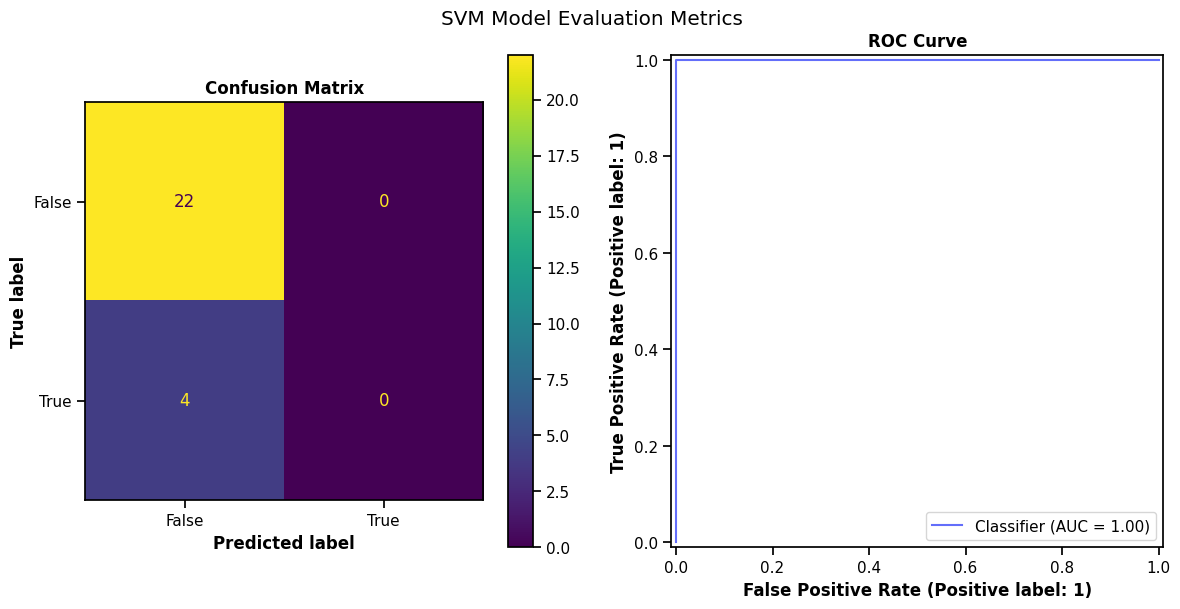

In [205]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
importlib.reload(bc)
def build_svm(data):
    X = data.drop(columns=["id", "DPN"])  # Features
    y = median_pivot["DPN"]  # Target

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Build and train the SVM model
    svm_model = SVC(kernel="rbf", random_state=42)
    svm_model.fit(X_scaled, y)
    return svm_model, X_scaled, y


def plot_cvm_result(svm_model, X_scaled, y):
    
    y_pred = svm_model.predict(X_scaled)
    print("Predictions:", y_pred)
    print(classification_report(y, y_pred))
    print("Accuracy:", accuracy_score(y, y_pred))
    res = {
            'confusion_matrix': bc.confusion_matrix(y, y_pred),
            'y_pred_proba': svm_model.decision_function(X_scaled)
        }

    # Call the function to plot evaluation metrics
    bc.plot_evaluation_metrics(res, y, title="SVM Model Evaluation Metrics")

plot_cvm_result(*build_svm(median_pivot))

In [206]:
import importlib
import general_utils.LDI_VIF as LV
importlib.reload(LV)

vif_median = median_pivot.copy()


def automatic_vif_reduction(data, keep_n=5):
    data=data.copy()
    removed_features = []
    for _ in range(len(data.columns) - 2 - keep_n):
        vif_data = LV.get_vif(data.drop(columns=['id', 'DPN']))
        max_vif_value = vif_data["Full VIF"].max()

        max_vif_col = vif_data.loc[vif_data["Full VIF"] == max_vif_value, "feature"].iloc[0]
        data = data.drop(columns=[max_vif_col])
        removed_features.append(max_vif_col)
    print(f"Removed: {removed_features}")
    return data, removed_features


def plot_vif_reduction(vif_median, removed_features):
    remaining_features = [col for col in vif_median.columns if col not in removed_features + ['id', 'DPN']]
    print(f"Remaining features: {remaining_features}")
    lda_df, lda = LV.perform_lda(vif_median, remaining_features)
    LV.plot_linear_lda(lda_df, "LDA results after VIF reduction")
    LV.show_linear_lda_stats(lda, remaining_features)
    LV.plot_vif(LV.get_vif(vif_median.drop(columns=['id', 'DPN'])))

#vif_median, removed_features = automatic_vif_reduction(median_pivot.copy())
#plot_vif_reduction(vif_median, removed_features)


Removed: ['SD1', 'SDRR', 'ApEn', 'Mean HR (bpm)', 'VLF Peak Frequency', 'DFA α1', 'LF Peak Frequency', 'RMSSD', 'HF Peak Frequency', 'DFA α2', 'SD2', 'LF÷HF Ratio', 'SampEn', 'LF Power']

 columns left: Index(['id', 'DPN', 'D2', 'HF Power', 'S', 'SD1÷SD2', 'VLF Power',
       'pNN50 (%)'],
      dtype='object', name='metric')
Predictions: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False]
              precision    recall  f1-score   support

       False       0.85      1.00      0.92        22
        True       0.00      0.00      0.00         4

    accuracy                           0.85        26
   macro avg       0.42      0.50      0.46        26
weighted avg       0.72      0.85      0.78        26

Accuracy: 0.8461538461538461


c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\326po\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

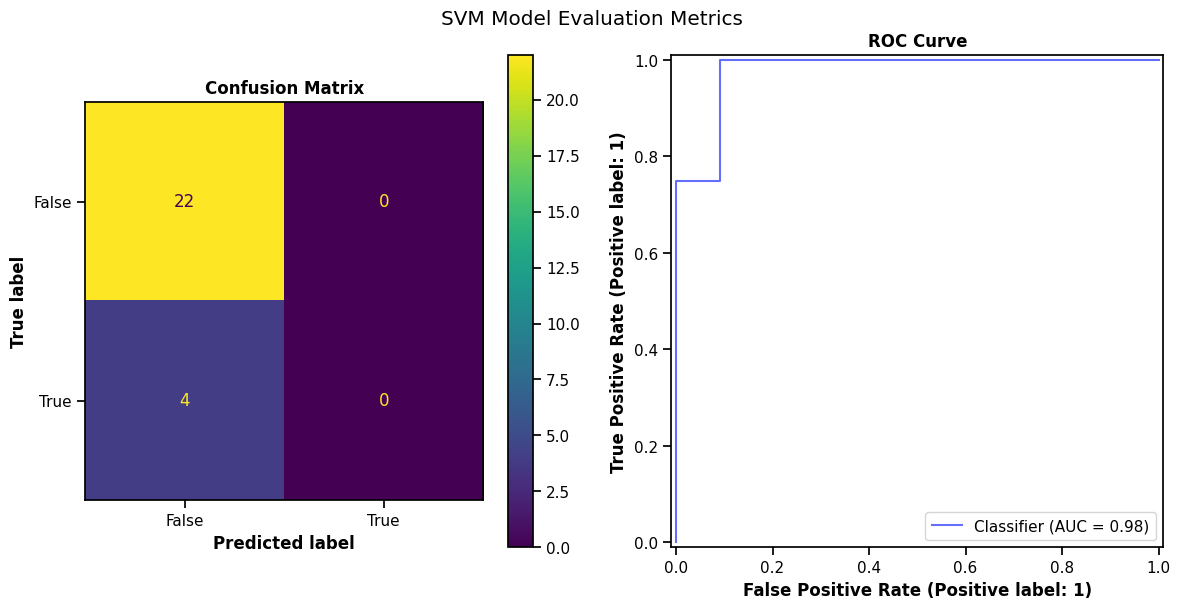

Remaining features: ['D2', 'HF Power', 'S', 'SD1÷SD2', 'VLF Power', 'pNN50 (%)']


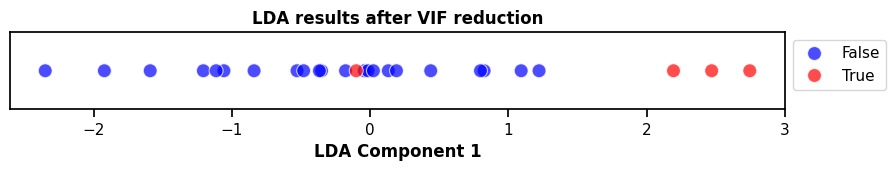

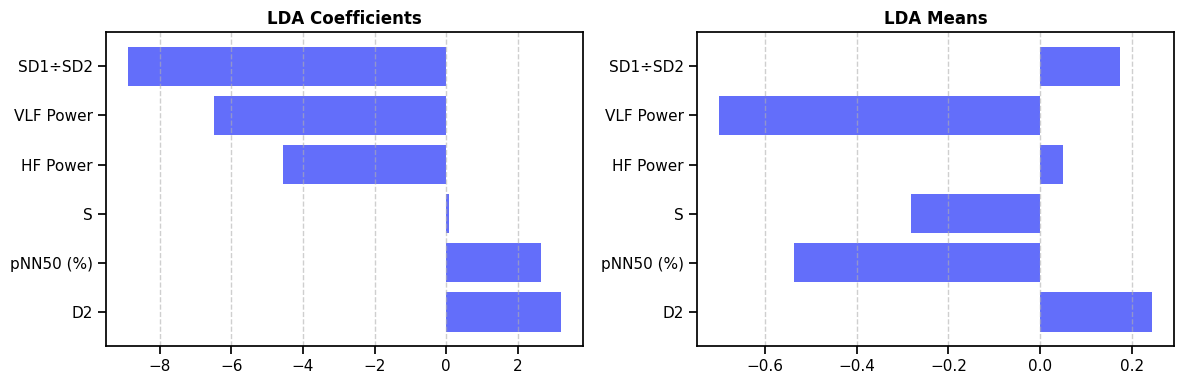

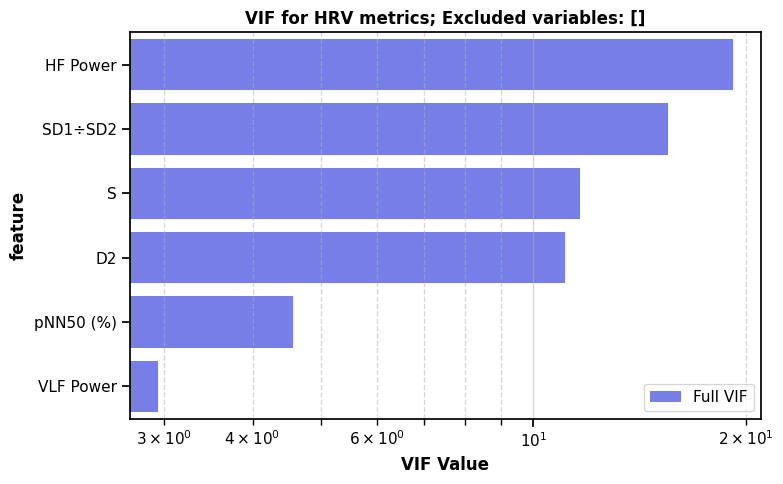

In [213]:

vif_median, removed_features = automatic_vif_reduction(median_pivot, 6)
print("\n columns left:",vif_median.columns)
plot_cvm_result(*build_svm(vif_median))
plot_vif_reduction(vif_median, removed_features)